In [3]:
import pandas as pd
from pathlib import Path


In [4]:
pip install openpyxl


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
from pathlib import Path

print("CWD:", os.getcwd())

# show a few matching files in the current folder
files = sorted([p.name for p in Path(".").glob("*Temp*.csv")])[:10]
print("Example Temp CSVs:", files)

files2 = sorted([p.name for p in Path(".").glob("*Humid*.csv")])[:10]
print("Example Humid CSVs:", files2)

CWD: /Users/asritha/Downloads/artresortation
Example Temp CSVs: ['1 Court Temp.csv', '1 Red Lion Temp.csv', '1 Schimmel Temp.csv', '3 End Shop Temp.csv', '3 Hart Temp.csv', '3 Shop Lane North Temp.csv', '3 Shop Lane South Temp.csv', '3 Tappahannock Temp.csv', '3 Windsor Room Temp.csv', '4 Blackwell Parlor Temp.csv']
Example Humid CSVs: ['1 Court Humid.csv', '1 Red Lion Humid.csv', '1 Schimmel Humid.csv', '3 End Shop Humid.csv', '3 Hart Humid.csv', '3 Shop Lane North Humid.csv', '3 Shop Lane South Humid.csv', '3 Tappahannock Humid.csv', '3 Windsor Room Humid.csv', '4 Blackwell Parlor Humid.csv']


In [7]:
survey_path = "updatedsurvey.xlsx"
survey = pd.read_excel(survey_path)
print(survey.columns)
survey.head()


Index(['Timestamp', 'Floor', 'Room', 'Name', 'Date', 'Time',
       'Temperature - Cool to Warm [Temperature]',
       'Humidity - Dry to Humid [Humidity]',
       'Air Movement - Still to Breezy [Air Movement]',
       'Other observations/notes'],
      dtype='object')


,Timestamp,Floor,Room,Name,Date,Time,Temperature - Cool to Warm [Temperature],Humidity - Dry to Humid [Humidity],Air Movement - Still to Breezy [Air Movement],Other observations/notes
0,2025-12-02 10:56:10.393,1,The Court,Christian West,2025-11-11,07:30:00,No Observation,Somewhat Humid,Still,NaN
1,2025-12-02 11:06:34.900,1,Webb Hall,Christian West,2025-11-11,07:25:00,No Observation,Somewhat Humid,Light movement,NaN
2,2025-12-02 10:56:39.481,1,The Court,Christian West,2025-11-12,07:30:00,Somewhat Warm,Somewhat Humid,Still,NaN
3,2025-12-02 11:07:05.810,1,Webb Hall,Christian West,2025-11-12,07:30:00,Somewhat Cool,No Observation,Light movement,NaN
4,2025-12-02 10:57:46.020,1,The Court,Christian West,2025-11-13,07:25:00,No Observation,Somewhat Humid,Still,NaN


In [1]:
import pandas as pd
from pathlib import Path
import re

BASE_DIR = Path(".")

ROOMS = [
    "1 Court",
    "1 Red Lion",
    "1 Schimmel",
    "3 End Shop",
    "3 Hart",
    "3 Shop Lane North",
    "3 Shop Lane South",
    "3 Tappahannock",
    "3 Windsor Room",
    "4 Blackwell Parlor",
    "4 Fraktur Room",
    "4 Hall of Statues",
    "4 Kershner Parlor",
    "4 Readbourne Passage",
    "4 Readbourne Parlor",
    "4 Readbourne",
    "4 Ulster County Room",
    "4 Wentworth Room",
]

# Explicit filename overrides for rooms that don't have their own Humid file
FILE_OVERRIDES = {
    "4 Readbourne Passage": {
        "temp": "4 Readbourne Passage Temp.csv",
        "humid": "4 Readbourne_Humid.csv",
    },
    "4 Readbourne Parlor": {
        "temp": "4 Readbourne Parlor_Temp.csv",
        "humid": "4 Readbourne_Humid.csv",
    },
}

def read_tritium_export(path: Path, out_value_name: str) -> pd.DataFrame:
    df = pd.read_csv(path, header=1)
    df.columns = [c.strip() for c in df.columns]

    value_col = next((c for c in df.columns if "value" in c.lower()), None)
    if value_col is None:
        raise ValueError(f"{path.name}: Value column not found. Columns={df.columns.tolist()}")

    ts = (
        df["Timestamp"].astype(str)
        .str.replace(r"\s+EDT$", "", regex=True)
        .str.replace(r"\s+EST$", "", regex=True)
    )

    # specify format to avoid warnings + speed up
    df["timestamp"] = pd.to_datetime(ts, format="%d-%b-%y %I:%M:%S %p", errors="coerce")
    df = df.dropna(subset=["timestamp"])

    df[out_value_name] = pd.to_numeric(df[value_col], errors="coerce")
    df["t15"] = df["timestamp"].dt.floor("15min")

    return df.groupby("t15", as_index=False)[out_value_name].mean()

def find_temp_humid_files(room: str):
    # use override if present
    if room in FILE_OVERRIDES:
        t = BASE_DIR / FILE_OVERRIDES[room]["temp"]
        h = BASE_DIR / FILE_OVERRIDES[room]["humid"]
        return t if t.exists() else None, h if h.exists() else None

    # normal case: "<room> Temp.csv" and "<room> Humid.csv"
    t = BASE_DIR / f"{room} Temp.csv"
    h = BASE_DIR / f"{room} Humid.csv"
    if t.exists() and h.exists():
        return t, h

    # fallback: contains matching (handles odd underscores)
    files = list(BASE_DIR.glob("*.csv"))
    room_low = room.lower()
    temp = next((f for f in files if room_low in f.stem.lower() and "temp" in f.stem.lower()), None)
    humid = next((f for f in files if room_low in f.stem.lower() and ("humid" in f.stem.lower() or "humidity" in f.stem.lower())), None)
    return temp, humid

def combine_room(room: str) -> pd.DataFrame:
    temp_path, humid_path = find_temp_humid_files(room)
    if not temp_path or not humid_path:
        raise FileNotFoundError(f"Missing Temp/Humid file for {room}: temp={temp_path} humid={humid_path}")

    temp_df = read_tritium_export(temp_path, "temp_f")
    rh_df   = read_tritium_export(humid_path, "rh_pct")

    merged = pd.merge(temp_df, rh_df, on="t15", how="outer").sort_values("t15")
    merged["room"] = room
    merged["temp_file"] = temp_path.name
    merged["humid_file"] = humid_path.name
    return merged

# ---- batch combine ----
all_rooms = []
missing = []

for room in ROOMS:
    try:
        df_room = combine_room(room)
        all_rooms.append(df_room)
        print(f" {room}: {len(df_room):,} rows ({df_room['t15'].min()} -> {df_room['t15'].max()})")
    except Exception as e:
        missing.append((room, str(e)))
        print(f" {room}: {e}")

final_tritium = pd.concat(all_rooms, ignore_index=True).sort_values(["room", "t15"]).reset_index(drop=True)
final_tritium.to_csv("tritium_temp_rh_all_rooms.csv", index=False)
print("\nSaved: tritium_temp_rh_all_rooms.csv")

if missing:
    print("\nRooms still missing:")
    for r, msg in missing:
        print(" -", r, ":", msg)

final_tritium.head()


 1 Court: 86,781 rows (2023-05-04 06:00:00 -> 2025-12-02 11:30:00)
 1 Red Lion: 83,022 rows (2023-05-04 05:15:00 -> 2025-12-02 11:30:00)
 1 Schimmel: 83,013 rows (2023-05-04 05:15:00 -> 2025-12-02 11:30:00)
 3 End Shop: 86,781 rows (2023-05-04 06:00:00 -> 2025-12-02 11:30:00)
 3 Hart: 83,102 rows (2023-05-04 05:15:00 -> 2025-12-02 11:30:00)
 3 Shop Lane North: 83,012 rows (2023-05-04 05:15:00 -> 2025-12-02 11:30:00)
 3 Shop Lane South: 89,621 rows (2023-05-09 10:45:00 -> 2025-12-02 11:30:00)
 3 Tappahannock: 86,781 rows (2023-05-04 06:00:00 -> 2025-12-02 11:30:00)
 3 Windsor Room: 86,781 rows (2023-05-04 06:00:00 -> 2025-12-02 11:30:00)
 4 Blackwell Parlor: 86,971 rows (2023-05-04 06:00:00 -> 2025-12-04 11:00:00)
 4 Fraktur Room: 83,293 rows (2023-05-04 05:15:00 -> 2025-12-04 11:00:00)
 4 Hall of Statues: 86,971 rows (2023-05-04 06:00:00 -> 2025-12-04 11:00:00)
 4 Kershner Parlor: 86,971 rows (2023-05-04 06:00:00 -> 2025-12-04 11:00:00)
 4 Readbourne Passage: 87,001 rows (2023-05-04 05

,t15,temp_f,rh_pct,room,temp_file,humid_file
0,2023-05-04 06:00:00,70.5,43.9,1 Court,1 Court Temp.csv,1 Court Humid.csv
1,2023-05-04 06:15:00,70.5,43.4,1 Court,1 Court Temp.csv,1 Court Humid.csv
2,2023-05-04 06:30:00,70.4,43.2,1 Court,1 Court Temp.csv,1 Court Humid.csv
3,2023-05-04 06:45:00,70.3,44.5,1 Court,1 Court Temp.csv,1 Court Humid.csv
4,2023-05-04 07:00:00,70.3,44.1,1 Court,1 Court Temp.csv,1 Court Humid.csv


In [22]:
survey = pd.read_excel("updatedsurvey.xlsx")


In [78]:
START = pd.Timestamp("2025-11-11")
END   = pd.Timestamp("2025-12-02")


In [79]:
CORE_ROOMS = ["1 Court", "3 End Shop", "4 Fraktur Room"]

survey_core = survey.copy()

survey_core = survey_core[
    (survey_core["survey_datetime"] >= START) &
    (survey_core["survey_datetime"] <= END) &
    (survey_core["tritium_room"].isin(CORE_ROOMS))
].copy()

print(survey_core["tritium_room"].value_counts())


tritium_room
1 Court           21
4 Fraktur Room    19
3 End Shop        18
Name: count, dtype: int64


In [80]:
tritium_core = tritium.copy()

tritium_core = tritium_core[
    (tritium_core["t15"] >= START) &
    (tritium_core["t15"] <= END) &
    (tritium_core["room"].isin(CORE_ROOMS))
].copy()


In [81]:
print(tritium_core.groupby(["room", tritium_core["t15"].dt.date]).size().head())


room     t15       
1 Court  2025-11-11    96
         2025-11-12    96
         2025-11-13    96
         2025-11-14    96
         2025-11-15    96
dtype: int64


In [69]:
survey["Room_clean"] = survey["Room"].astype(str).str.strip()
print(survey["Room_clean"].value_counts().head(50))


Room_clean
The Court             39
Port Royal Parlor     38
Memorial Library      38
Blue Room             38
Fraktur Room          37
Dupont Dining Room    37
Williams Room         37
Cecil Hall            37
Lebanon Bedroom       37
Pottery Room          37
End Shop              36
Marlboro Hall         36
Webb Hall             35
China Room            34
Billiards Room        34
Name: count, dtype: int64


In [82]:
merged = []

for room in CORE_ROOMS:
    s = (
        survey_core[survey_core["tritium_room"] == room]
        .sort_values("survey_datetime")
    )

    t = (
        tritium_core[tritium_core["room"] == room]
        .sort_values("t15")
    )

    m = pd.merge_asof(
        s,
        t,
        left_on="survey_datetime",
        right_on="t15",
        direction="nearest",
        tolerance=pd.Timedelta("15min")
    )

    m["room"] = room
    merged.append(m)

final = pd.concat(merged, ignore_index=True)


In [83]:
final["time_diff_min"] = (
    (final["survey_datetime"] - final["t15"])
    .abs()
    .dt.total_seconds() / 60
)

final["time_diff_min"].describe()


count    58.000000
mean      2.844828
std       2.594202
min       0.000000
25%       0.000000
50%       3.000000
75%       5.000000
max       7.000000
Name: time_diff_min, dtype: float64

In [84]:
final.groupby("room").size()


room
1 Court           21
3 End Shop        18
4 Fraktur Room    19
dtype: int64

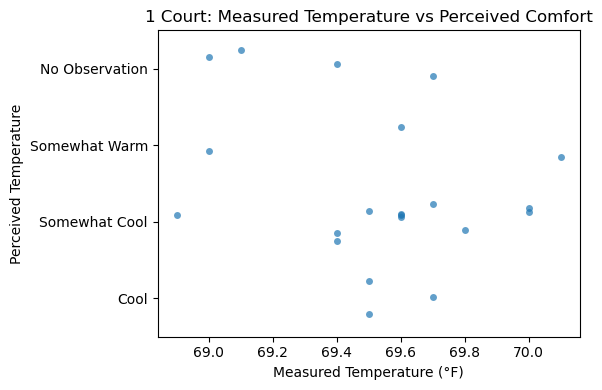

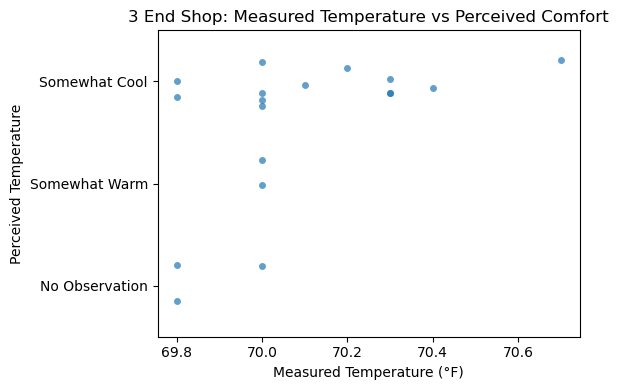

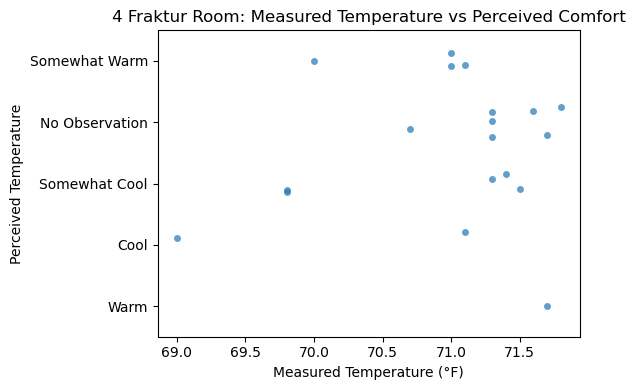

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

for room in final["room"].unique():
    df = final[final["room"] == room]

    plt.figure(figsize=(6,4))
    sns.stripplot(
        data=df,
        x="temp_f",
        y="Temperature - Cool to Warm [Temperature]",
        jitter=0.25,
        alpha=0.7
    )

    plt.title(f"{room}: Measured Temperature vs Perceived Comfort")
    plt.xlabel("Measured Temperature (°F)")
    plt.ylabel("Perceived Temperature")
    plt.tight_layout()
    plt.show()


In [59]:
survey_core[["survey_datetime"]].head(10)


,survey_datetime
14,2025-11-18 07:45:00
18,2025-11-20 08:10:00
37,2025-12-02 08:15:00
87,2025-11-18 07:25:00
91,2025-11-20 07:45:00
112,2025-12-02 08:10:00
159,2025-11-18 08:10:00
163,2025-11-20 07:52:00
185,2025-12-02 07:41:00


In [60]:
survey_core["survey_datetime"].dtype


dtype('<M8[ns]')

In [61]:
survey_core["survey_datetime"].isna().sum(), len(survey_core)


(np.int64(0), 9)

In [62]:
tritium[["t15"]].head(10)



,t15
85390,2025-11-18 00:00:00
85391,2025-11-18 00:15:00
85392,2025-11-18 00:30:00
85393,2025-11-18 00:45:00
85394,2025-11-18 01:00:00
85395,2025-11-18 01:15:00
85396,2025-11-18 01:30:00
85397,2025-11-18 01:45:00
85398,2025-11-18 02:00:00
85399,2025-11-18 02:15:00


In [63]:
tritium["t15"].dtype

dtype('<M8[ns]')

In [64]:
tritium["t15"].isna().sum(), len(tritium)


(np.int64(0), 766)

In [65]:
survey_core["date"] = survey_core["survey_datetime"].dt.date
tritium["date"] = tritium["t15"].dt.date

print("Survey dates:", sorted(survey_core["date"].unique()))
print("Tridium dates:", sorted(tritium["date"].unique())[-10:])


Survey dates: [datetime.date(2025, 11, 18), datetime.date(2025, 11, 20), datetime.date(2025, 12, 2)]
Tridium dates: [datetime.date(2025, 11, 18), datetime.date(2025, 11, 20), datetime.date(2025, 12, 2)]


In [66]:
final.groupby("room").agg(
    survey_min=("survey_datetime", "min"),
    survey_max=("survey_datetime", "max"),
    tritium_min=("t15", "min"),
    tritium_max=("t15", "max"),
)


,survey_min,survey_max,tritium_min,tritium_max
room,,,,
1 Court,2025-11-18 07:45:00,2025-12-02 08:15:00,2025-11-18 07:45:00,2025-12-02 08:15:00
3 End Shop,2025-11-18 07:25:00,2025-12-02 08:10:00,2025-11-18 07:30:00,2025-12-02 08:15:00
4 Fraktur Room,2025-11-18 08:10:00,2025-12-02 07:41:00,2025-11-18 08:15:00,2025-12-02 07:45:00


In [67]:
final["temp_feel"] = final["Temperature - Cool to Warm [Temperature]"]


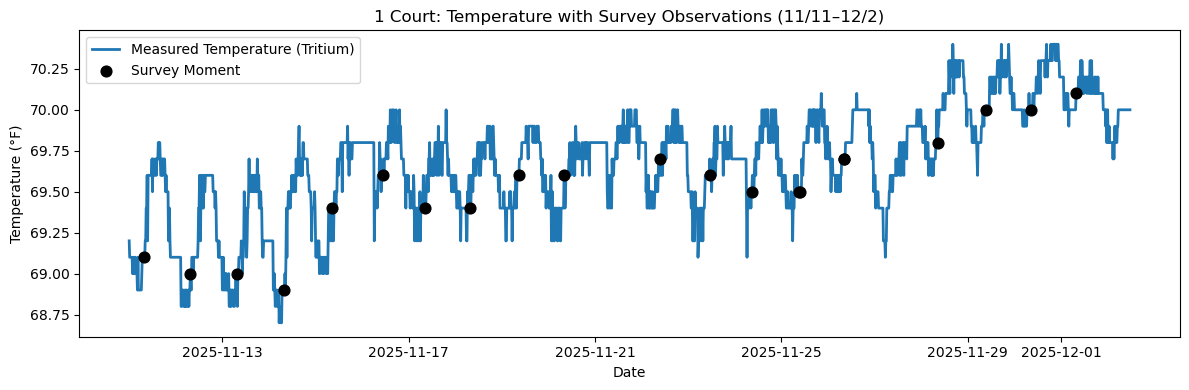

In [88]:
import matplotlib.pyplot as plt

room = "1 Court"

t_room = tritium[tritium["room"] == room].copy()
s_room = final[final["tritium_room"] == room].copy()

fig, ax = plt.subplots(figsize=(12,4))


ax.plot(
    t_room["t15"],
    t_room["temp_f"],
    label="Measured Temperature (Tritium)",
    linewidth=2
)


ax.scatter(
    s_room["survey_datetime"],
    s_room["temp_f"],
    c="black",
    s=60,
    zorder=3,
    label="Survey Moment"
)

ax.set_title(f"{room}: Temperature with Survey Observations (11/11–12/2)")
ax.set_ylabel("Temperature (°F)")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()


In [92]:

exact_table = final[[
    "room",
    "survey_datetime",
    "t15",
    "temp_f",
    "rh_pct",
    "Temperature - Cool to Warm [Temperature]",
    "Humidity - Dry to Humid [Humidity]",
    "time_diff_min"
]].copy()


exact_table = exact_table.rename(columns={
    "t15": "tritium_datetime",
    "Temperature - Cool to Warm [Temperature]": "perceived_temperature",
    "Humidity - Dry to Humid [Humidity]": "perceived_humidity"
})


exact_table = exact_table.sort_values(
    ["room", "survey_datetime"]
).reset_index(drop=True)

exact_table


,room,survey_datetime,tritium_datetime,temp_f,rh_pct,perceived_temperature,perceived_humidity,time_diff_min
0,1 Court,2025-11-11 07:30:00,2025-11-11 07:30:00,69.1,41.2,No Observation,Somewhat Humid,0.0
1,1 Court,2025-11-12 07:30:00,2025-11-12 07:30:00,69.0,41.6,Somewhat Warm,Somewhat Humid,0.0
2,1 Court,2025-11-13 07:25:00,2025-11-13 07:30:00,69.0,42.2,No Observation,Somewhat Humid,5.0
3,1 Court,2025-11-14 07:30:00,2025-11-14 07:30:00,68.9,41.8,Somewhat Cool,No Observation,0.0
4,1 Court,2025-11-15 08:32:00,2025-11-15 08:30:00,69.4,42.0,Somewhat Cool,Somewhat Dry,2.0
5,1 Court,2025-11-16 10:42:00,2025-11-16 10:45:00,69.6,43.7,Somewhat Cool,Somewhat Dry,3.0
6,1 Court,2025-11-17 08:30:00,2025-11-17 08:30:00,69.4,41.7,No Observation,No Observation,0.0
7,1 Court,2025-11-18 07:45:00,2025-11-18 07:45:00,69.4,41.5,Somewhat Cool,Somewhat Dry,0.0
8,1 Court,2025-11-19 08:45:00,2025-11-19 08:45:00,69.6,43.6,Somewhat Cool,Somewhat Dry,0.0
9,1 Court,2025-11-20 08:10:00,2025-11-20 08:15:00,69.6,42.1,Somewhat Warm,Dry,5.0


In [94]:
final.columns.tolist()


['Timestamp',
 'Floor',
 'Room',
 'Name',
 'Date',
 'Time',
 'Temperature - Cool to Warm [Temperature]',
 'Humidity - Dry to Humid [Humidity]',
 'Air Movement - Still to Breezy [Air Movement]',
 'Other observations/notes',
 'Room_clean',
 'tritium_room',
 'survey_datetime',
 'date_x',
 't15',
 'temp_f',
 'rh_pct',
 'room',
 'temp_file',
 'humid_file',
 'date_y',
 'room_clean',
 'time_diff_min']

In [95]:
# normalize column names (optional but helpful)
final = final.rename(columns={
    "Perceived Temperature": "perceived_temperature",
    "Perceived Humidity": "perceived_humidity",
    "perceived_temperature_x": "perceived_temperature",
    "perceived_humidity_x": "perceived_humidity",
})

# confirm
final[["room", "temp_f"]].head()


,room,temp_f
0,1 Court,69.1
1,1 Court,69.0
2,1 Court,69.0
3,1 Court,68.9
4,1 Court,69.4


In [97]:
rename_map = {
    "Perceived Temperature": "perceived_temperature",
    "Perceived Humidity": "perceived_humidity",
    "perceived_temperature_x": "perceived_temperature",
    "perceived_humidity_x": "perceived_humidity",
    "perceived_temperature_y": "perceived_temperature",
    "perceived_humidity_y": "perceived_humidity",
}

final = final.rename(columns={k:v for k,v in rename_map.items() if k in final.columns})


In [98]:
"perceived_temperature" in final.columns, "perceived_humidity" in final.columns


(False, False)

In [103]:
final = final.rename(columns={
    "Temperature - Cool to Warm [Temperature]": "felt_temperature",
    "Humidity - Dry to Humid [Humidity]": "felt_humidity"
})


In [104]:
cols = [
    "room",
    "survey_datetime",
    "t15",          # or "tritium_datetime" if you renamed it earlier
    "temp_f",
    "rh_pct",
    "felt_temperature",
    "felt_humidity",
    "time_diff_min"
]

# If your tritium timestamp column is called "tritium_datetime", swap it in:
if "t15" not in final.columns and "tritium_datetime" in final.columns:
    cols[2] = "tritium_datetime"

table_all = (
    final[cols]
    .sort_values(["room", "survey_datetime"])
    .reset_index(drop=True)
)

table_all


,room,survey_datetime,t15,temp_f,rh_pct,felt_temperature,felt_humidity,time_diff_min
0,1 Court,2025-11-11 07:30:00,2025-11-11 07:30:00,69.1,41.2,No Observation,Somewhat Humid,0.0
1,1 Court,2025-11-12 07:30:00,2025-11-12 07:30:00,69.0,41.6,Somewhat Warm,Somewhat Humid,0.0
2,1 Court,2025-11-13 07:25:00,2025-11-13 07:30:00,69.0,42.2,No Observation,Somewhat Humid,5.0
3,1 Court,2025-11-14 07:30:00,2025-11-14 07:30:00,68.9,41.8,Somewhat Cool,No Observation,0.0
4,1 Court,2025-11-15 08:32:00,2025-11-15 08:30:00,69.4,42.0,Somewhat Cool,Somewhat Dry,2.0
5,1 Court,2025-11-16 10:42:00,2025-11-16 10:45:00,69.6,43.7,Somewhat Cool,Somewhat Dry,3.0
6,1 Court,2025-11-17 08:30:00,2025-11-17 08:30:00,69.4,41.7,No Observation,No Observation,0.0
7,1 Court,2025-11-18 07:45:00,2025-11-18 07:45:00,69.4,41.5,Somewhat Cool,Somewhat Dry,0.0
8,1 Court,2025-11-19 08:45:00,2025-11-19 08:45:00,69.6,43.6,Somewhat Cool,Somewhat Dry,0.0
9,1 Court,2025-11-20 08:10:00,2025-11-20 08:15:00,69.6,42.1,Somewhat Warm,Dry,5.0


In [136]:
final.columns


Index(['Timestamp', 'Floor', 'Room', 'Name', 'Date', 'Time',
       'felt_temperature', 'felt_humidity',
       'Air Movement - Still to Breezy [Air Movement]',
       'Other observations/notes', 'Room_clean', 'tritium_room',
       'survey_datetime', 'date_x', 't15', 'temp_f', 'rh_pct', 'room',
       'temp_file', 'humid_file', 'date_y', 'room_clean', 'time_diff_min'],
      dtype='object')

In [137]:
temp_counts = (
    final.groupby(["room", "felt_temperature","Name"])
    .size()
    .reset_index(name="n")
    .sort_values(["room", "n"], ascending=[True, False])
)

temp_counts


,room,felt_temperature,Name,n
3,1 Court,Somewhat Cool,Bill Smith,6
0,1 Court,Cool,Will McHugh,3
1,1 Court,No Observation,Christian West,3
4,1 Court,Somewhat Cool,Christian West,3
7,1 Court,Somewhat Warm,Christian West,2
2,1 Court,No Observation,Will McHugh,1
5,1 Court,Somewhat Cool,Connor Pearson,1
6,1 Court,Somewhat Cool,Will McHugh,1
8,1 Court,Somewhat Warm,Connor Pearson,1
11,3 End Shop,Somewhat Cool,Bill Smith,6


In [138]:
final = final.rename(columns={
    "Temperature - Cool to Warm [Temperature]": "felt_temperature",
    "Humidity - Dry to Humid [Humidity]": "felt_humidity"
})


In [139]:
summary = (
    final
    .groupby(["room", "felt_temperature","Name"])
    .agg(
        n=("temp_f", "count"),
        temp_min=("temp_f", "min"),
        temp_max=("temp_f", "max"),
        dates=("survey_datetime", lambda x: sorted(x.dt.date.unique()))
    )
    .reset_index()
)

summary


,room,felt_temperature,Name,n,temp_min,temp_max,dates
0,1 Court,Cool,Will McHugh,3,69.5,69.7,"[2025-11-25, 2025-11-26]"
1,1 Court,No Observation,Christian West,3,69.0,69.4,"[2025-11-11, 2025-11-13, 2025-11-17]"
2,1 Court,No Observation,Will McHugh,1,69.7,69.7,[2025-11-26]
3,1 Court,Somewhat Cool,Bill Smith,6,69.4,70.0,"[2025-11-15, 2025-11-16, 2025-11-22, 2025-11-2..."
4,1 Court,Somewhat Cool,Christian West,3,68.9,69.6,"[2025-11-14, 2025-11-18, 2025-11-19]"
5,1 Court,Somewhat Cool,Connor Pearson,1,69.8,69.8,[2025-11-28]
6,1 Court,Somewhat Cool,Will McHugh,1,69.5,69.5,[2025-11-24]
7,1 Court,Somewhat Warm,Christian West,2,69.0,69.6,"[2025-11-12, 2025-11-20]"
8,1 Court,Somewhat Warm,Connor Pearson,1,70.1,70.1,[2025-12-01]
9,3 End Shop,No Observation,Christian West,2,69.8,70.0,"[2025-11-20, 2025-11-21]"


In [111]:
final.groupby("room").size()


room
1 Court           21
3 End Shop        18
4 Fraktur Room    19
dtype: int64

In [140]:
(
  final.groupby(["room", "felt_temperature","Name",])
       .size()
       .reset_index(name="n")
       .sort_values(["room", "n"], ascending=[True, False])
)


,room,felt_temperature,Name,n
3,1 Court,Somewhat Cool,Bill Smith,6
0,1 Court,Cool,Will McHugh,3
1,1 Court,No Observation,Christian West,3
4,1 Court,Somewhat Cool,Christian West,3
7,1 Court,Somewhat Warm,Christian West,2
2,1 Court,No Observation,Will McHugh,1
5,1 Court,Somewhat Cool,Connor Pearson,1
6,1 Court,Somewhat Cool,Will McHugh,1
8,1 Court,Somewhat Warm,Connor Pearson,1
11,3 End Shop,Somewhat Cool,Bill Smith,6


In [141]:
(
  final.groupby(["room", "felt_humidity","Name"])
       .size()
       .reset_index(name="n")
       .sort_values(["room", "n"], ascending=[True, False])
)


,room,felt_humidity,Name,n
4,1 Court,Somewhat Dry,Bill Smith,6
7,1 Court,Somewhat Dry,Will McHugh,3
8,1 Court,Somewhat Humid,Christian West,3
2,1 Court,No Observation,Christian West,2
5,1 Court,Somewhat Dry,Christian West,2
0,1 Court,Dry,Christian West,1
1,1 Court,Dry,Will McHugh,1
3,1 Court,No Observation,Will McHugh,1
6,1 Court,Somewhat Dry,Connor Pearson,1
9,1 Court,Somewhat Humid,Connor Pearson,1


In [132]:
def plot_temperature_by_room(room):
    df = (
        final[final["room"] == room]
        .sort_values("survey_datetime")
        .reset_index(drop=True)
    )

    plt.figure(figsize=(10, 4))

    for label, g in df.groupby("felt_temperature"):
        plt.scatter(g.index, g["temp_f"], label=label, s=70)

    plt.xticks(
        ticks=df.index,
        labels=df["survey_datetime"].dt.strftime("%m/%d"),
        rotation=45
    )

    plt.title(f"{room}: Measured Temperature at Each Survey Moment")
    plt.xlabel("Survey date")
    plt.ylabel("Measured temperature (°F)")
    plt.legend(title="Felt temperature", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [133]:
def plot_humidity_by_room(room):
    df = (
        final[final["room"] == room]
        .sort_values("survey_datetime")
        .reset_index(drop=True)
    )

    plt.figure(figsize=(10, 4))

    for label, g in df.groupby("felt_humidity"):
        plt.scatter(g.index, g["rh_pct"], label=label, s=70)

    plt.xticks(
        ticks=df.index,
        labels=df["survey_datetime"].dt.strftime("%m/%d"),
        rotation=45
    )

    plt.title(f"{room}: Measured Humidity at Each Survey Moment")
    plt.xlabel("Survey date")
    plt.ylabel("Relative humidity (%)")
    plt.legend(title="Felt humidity", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


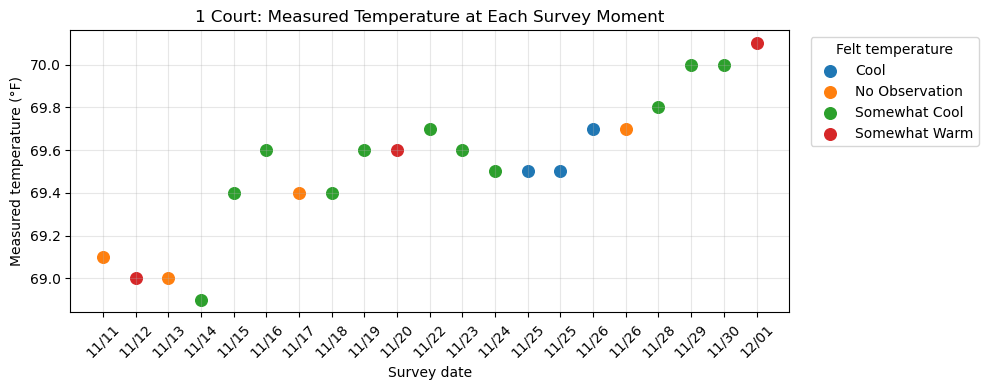

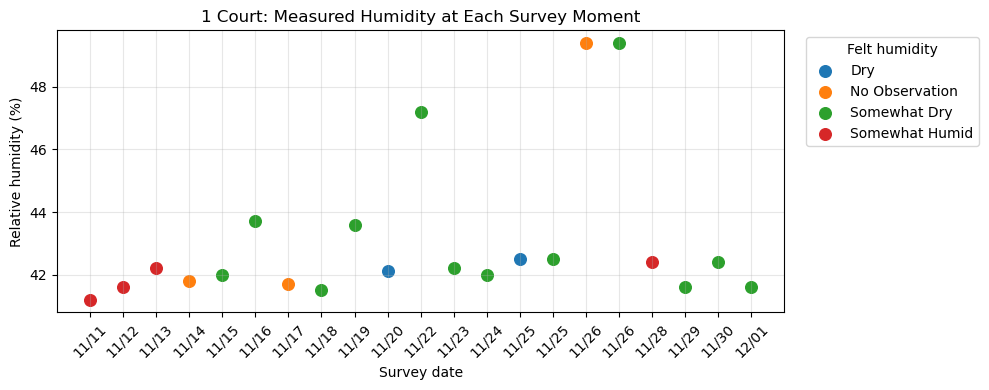

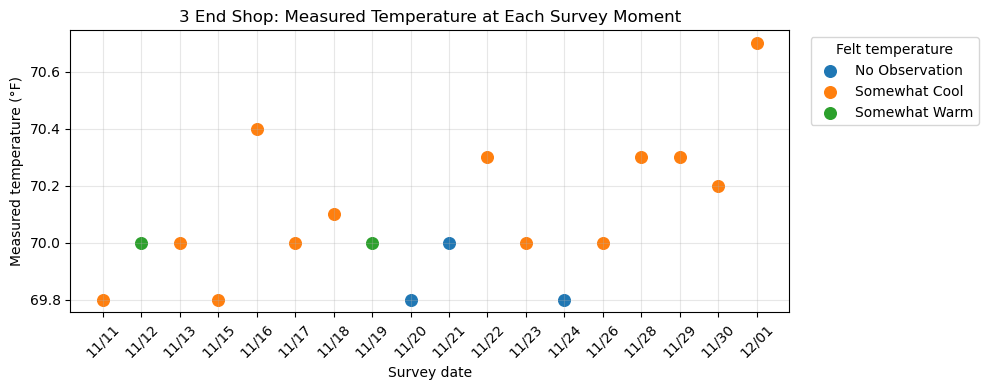

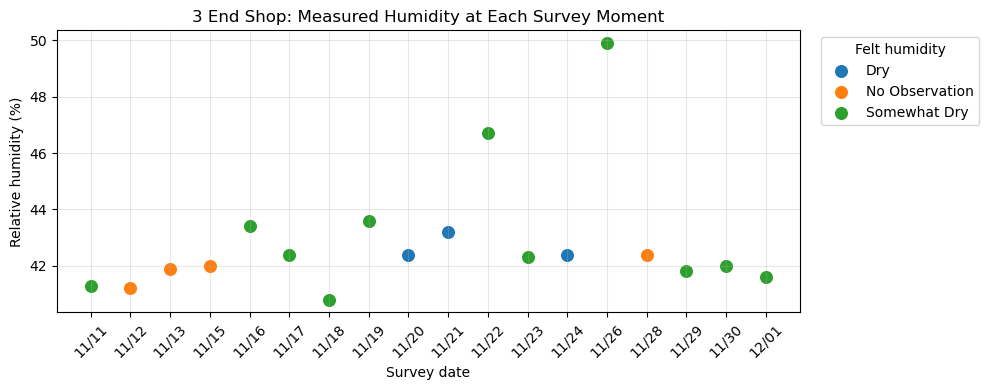

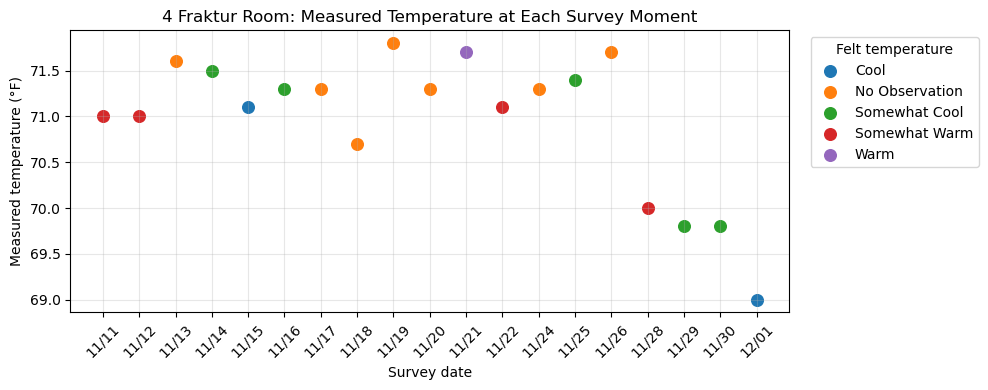

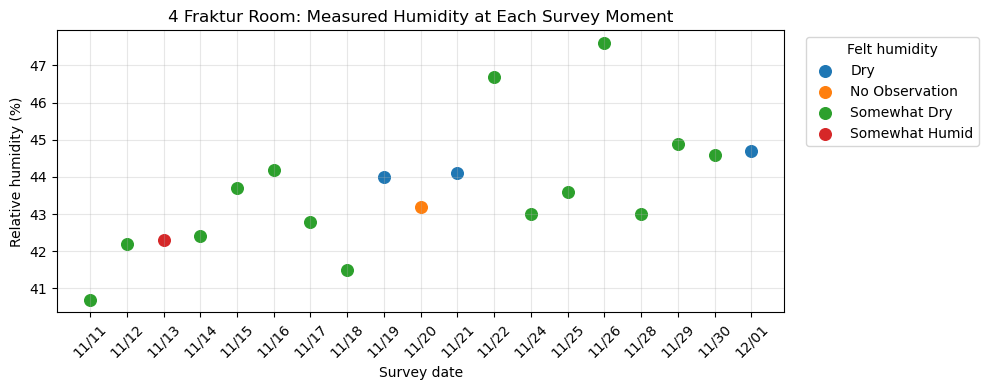

In [134]:
for r in ["1 Court", "3 End Shop", "4 Fraktur Room"]:
    plot_temperature_by_room(r)
    plot_humidity_by_room(r)
